In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from jax import random, vmap
import jax.numpy as jnp
from jax.scipy.special import logsumexp

import numpyro
from numpyro import handlers
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

$$\begin{align*}
M = 2A+1 \\
D = A + M
\end{align*}$$

/Users/graceliu/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/graceliu/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/graceliu/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/graceliu/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/graceliu/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/Users/graceliu/miniconda3/lib/python3.12/site-pac

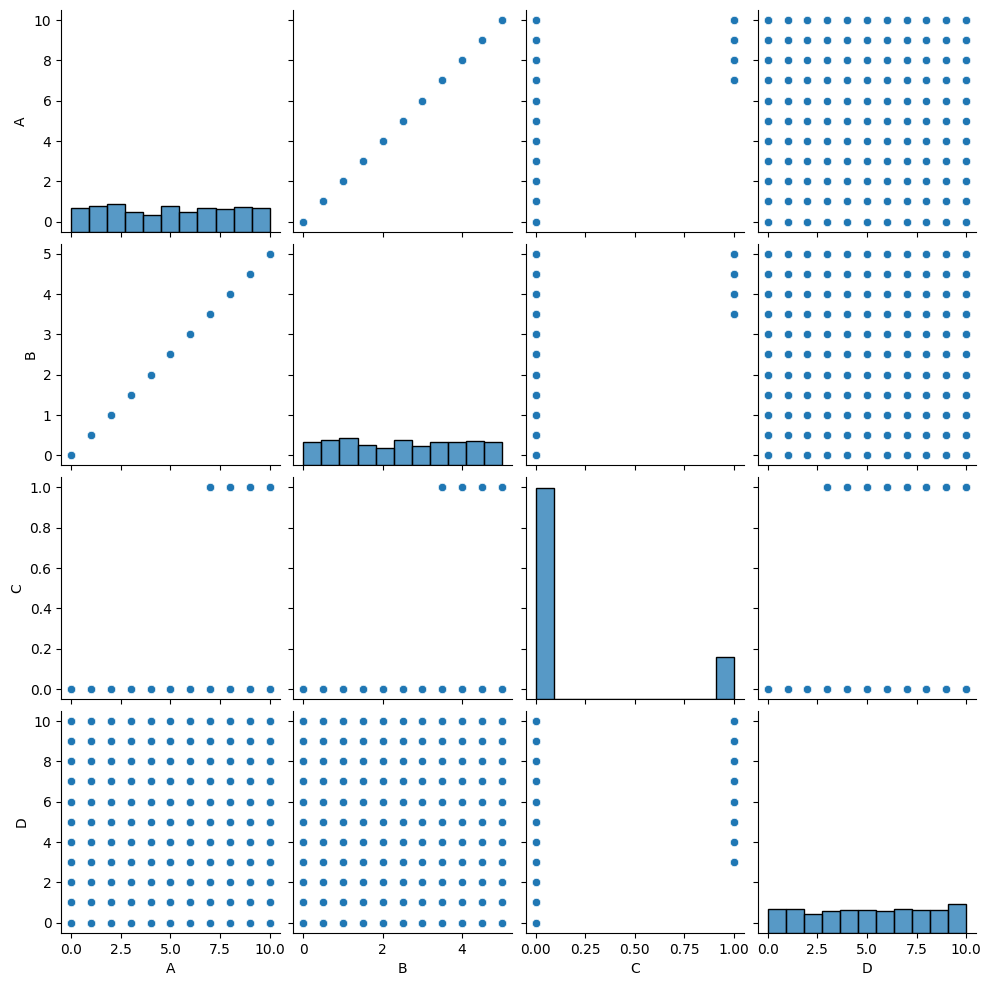

In [75]:
# Load data file
dset = pd.read_csv("data/abcd_dag.csv", sep=",")

def standardize(x):
    return (x-x.mean(0)) / x.std(0)

y = dset["D"].values
X = dset[["A", "B", "C"]].values

vars = [
    "A",
    "B",
    "C",
    "D"
]
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette="husl")
plt.show()

X = standardize(X)
y = standardize(y)


In [76]:
def model(X, y=None):
    # a = numpyro.sample("a", dist.Normal(0, 0.2))

    b = numpyro.sample("b", dist.Normal(0, 1).expand([X.shape[1]]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    mu = jnp.dot(X, b)
    numpyro.sample("y", dist.Bernoulli(mu), obs=y)

def hs_model(X, y=None, sigma=1):
        '''
        Parameters:
           array y: dependent variable
           int sigma: stdev of y
        '''
        N, D = X.shape
        hc_lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones([D])))
        hc_tau = numpyro.sample('tau', dist.HalfCauchy(1))

        # slightly different parametrization for efficiency
        hc_unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, jnp.ones([D])))
        hc_scaled_betas = numpyro.deterministic("betas", hc_tau*hc_lambdas*hc_unscaled_betas)

        hc_kappas = numpyro.deterministic("kappas", 1 / (1 + N * hc_tau**2 * hc_lambdas**2))

        y_mean = jnp.dot(X, hc_scaled_betas)

        numpyro.sample('y', dist.Bernoulli(y_mean), obs=y)

In [80]:
rng_key = random.PRNGKey(2)
nuts = NUTS(hs_model)
mcmc = MCMC(nuts, num_warmup = 1000, num_samples=2000, num_chains=4)
mcmc.run(
    rng_key, 
    X=X,
    y=y
)
mcmc.print_summary()

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_62492/2010862341.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup = 1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [00:11<00:00, 265.91it/s, 87 steps of size 6.26e-04. acc. prob=0.82]  


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
       lambdas[0]      0.53      0.54      0.31      0.01      1.25      4.56      1.50
       lambdas[1]      0.77      0.65      0.60      0.00      1.81      2.21      4.59
       lambdas[2]      2.01      1.22      1.77      0.31      3.59      2.18      7.44
              tau      1.11      0.93      0.66      0.26      2.66      2.02     15.66
unscaled_betas[0]     -1.09      0.74     -1.08     -2.21     -0.18      3.42      2.11
unscaled_betas[1]     -0.35      0.93     -0.62     -1.56      0.97      2.06      6.65
unscaled_betas[2]      0.81      0.53      0.86      0.06      1.60      2.14      4.78

Number of divergences: 1000


In [83]:
samples = mcmc.get_samples()

{'betas': Array([[-3.0489042e-01, -1.2328273e-01,  5.7088083e-01],
        [-3.0535215e-01, -1.2449036e-01,  5.7074893e-01],
        [-3.0494106e-01, -1.2668464e-01,  5.7082546e-01],
        ...,
        [-4.3020537e-01, -9.0177100e-06,  5.6984615e-01],
        [-4.2985192e-01, -9.0198519e-06,  5.7015520e-01],
        [-4.2987573e-01, -9.0175699e-06,  5.7179725e-01]], dtype=float32),
 'kappas': Array([[5.6095524e-03, 4.1192403e-04, 5.7094996e-03],
        [5.6053181e-03, 4.1116614e-04, 5.7096276e-03],
        [5.7533067e-03, 4.0874997e-04, 5.6441659e-03],
        ...,
        [1.1638608e-02, 1.0000000e+00, 2.2967481e-05],
        [1.1655555e-02, 1.0000000e+00, 2.3002167e-05],
        [1.1662286e-02, 1.0000000e+00, 2.3008080e-05]], dtype=float32),
 'lambdas': Array([[4.8373666e-01, 1.7897674e+00, 4.7945988e-01],
        [4.8389545e-01, 1.7913247e+00, 4.7942978e-01],
        [4.7685996e-01, 1.7938449e+00, 4.8147482e-01],
        ...,
        [1.5681002e-01, 2.3713974e-06, 3.5506248e+00],

In [84]:
betas = samples["betas"]
mean_betas = betas.mean(0)
mean_betas

Array([-0.39833602, -0.03784565,  0.5782093 ], dtype=float32)

In [ ]:
samples_1 = mcmc.get_samples()
predictive = Predictive(hs_model, samples_1)
predictions = predictive(random.PRNGKey(0), 
                         X=X,
                         y=y)['y']
predictions


Array([[ 0.2186928, -1.0112752, -1.4604175, ..., -1.4596606,  1.333564 ,
        -0.7313626],
       [ 0.2186928, -1.0112752, -1.4604175, ..., -1.4596606,  1.333564 ,
        -0.7313626],
       [ 0.2186928, -1.0112752, -1.4604175, ..., -1.4596606,  1.333564 ,
        -0.7313626],
       ...,
       [ 0.2186928, -1.0112752, -1.4604175, ..., -1.4596606,  1.333564 ,
        -0.7313626],
       [ 0.2186928, -1.0112752, -1.4604175, ..., -1.4596606,  1.333564 ,
        -0.7313626],
       [ 0.2186928, -1.0112752, -1.4604175, ..., -1.4596606,  1.333564 ,
        -0.7313626]], dtype=float32)

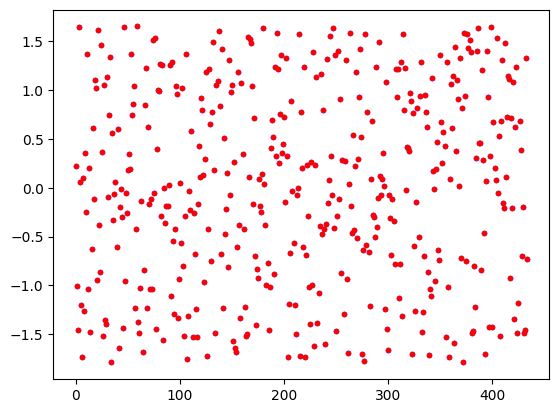

In [ ]:
mean_pred = predictions.mean(axis=0)
plt.plot(range(len(mean_pred)), mean_pred, 'b.')
plt.plot(range(len(y)), y, 'r.')
plt.show()

In [ ]:
mean_betas = samples_1['betas'].mean(0)
print(sum((jnp.dot(X, mean_betas)) - y))


-6.67572e-06
